# Thinking

In [ ]:
Thinking1：在CTR点击率预估中，使用GBDT+LR的原理是什么？

    当样本量大时，LR学习能力有限，模型拟合效果不好。采用GBDT可以用来发掘有区分度的特征，增加模型效果。GBDT主要进行特征构造，LR用来分类。
    
    
Thinking2：Wide & Deep的模型结构是怎样的，为什么能通过具备记忆和泛化能力（memorization and generalization）

    Wide：memorization记忆能力，学习items或者features之间的相关频率，在历史数据中探索相关性的可行性；
    Deep：generalization泛化（推理）能力，基于相关性的传递，去探索一些在过去没有出现过的特征组合。
    Wide模型是LR模型，可以进行有效记忆；Deep模型是深度模型，可以将特征映射到高纬空间，增加模型特征和稠密度，
同时对Wide模型和Deep模型进行训练，从而使模型具有记忆力和泛化能力。


Thinking3：在CTR预估中，使用FM与DNN结合的方式，有哪些结合的方式，代表模型有哪些？

    1.结合方式有并行(Bagging)和串行（Bossting）；
    2.代表模型:
        DeepFM（并行），通过FM与DNN结合，获得高阶特征；
        NFM（串行）。

Thinking4：GBDT和随机森林都是基于树的算法，它们有什么区别？

    1.GBDT属于Boosting模型(串行)，RF属于Bagging模型（并行）；
    2.随机森林的树可以是分类树，也可以是回归树；而GBDT只能由回归树组成；
    3.随机森林是通过减少模型方差提高性能，GBDT是通过减少模型偏差提高性能；

    
Thinking5：item流行度在推荐系统中有怎样的应用？

    1.解决冷启动问题:将流行度较高的商品推荐给用户，如对于新用户，采用非个性化推荐（基于流行度的推荐）；
    2.个性化推荐：给用户推荐流行度较低的item，如对于老用户，可以考虑高流行度对商品推荐的降权影响，挖掘长尾。

# Action 使用Wide&Deep模型对movielens进行评分预测

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import WDL
from deepctr.feature_column import SparseFeat,get_feature_names

In [6]:
# 数据加载
data = pd.read_csv(r"L5/wide_deep/movielens_sample.txt")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
target = ['rating']
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408
3,785,2115,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,M,18,19,29307
4,5848,909,5,957782527,"Apartment, The (1960)",Comedy|Drama,M,50,20,20009


In [12]:
# 特征编码 LabelEncoder
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,107,12,4,968035345,Ed Wood (1994),Comedy|Drama,0,2,4,35
1,123,169,3,966536874,Patriot Games (1992),Action|Thriller,1,1,4,118
2,12,6,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,0,2,13,99
3,21,112,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,1,1,18,55
4,187,45,5,957782527,"Apartment, The (1960)",Comedy|Drama,1,5,19,41


In [14]:
# 计算每个特征中的 不同特征值的个数
fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique()) for feature in sparse_features]
linear_feature_columns = fixlen_feature_columns # wide
dnn_feature_columns = fixlen_feature_columns    # deep


In [16]:
# 组合特征
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
feature_names[:10]

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip']

In [17]:
SparseFeat(name='userId', vocabulary_size=7120, embedding_dim=4)

SparseFeat(name='userId', vocabulary_size=7120, embedding_dim=4, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.RandomNormal object at 0x00000258B4C44518>, embedding_name='userId', group_name='default_group', trainable=True)

In [21]:
# 拆分数据集
train, test = train_test_split(data, test_size=0.2,random_state=2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [37]:
# 建模：WDL
model = WDL(linear_feature_columns, 
            dnn_feature_columns, 
            task='regression',
            dnn_hidden_units=(256,256)
           )
# 编译模型
model.compile(optimizer="adam",loss= "mse", metrics=['mse']) 

# Train
history = model.fit(train_model_input, 
                    train[target].values, 
                    batch_size=256, 
                    epochs=10, 
                    verbose=1, 
                    validation_split=0.2,
                    workers=2
                   )
# 输出在连续时期训练损失值和度量值以及验证损失值和验证度量值（如果适用）的记录
hist = history.history
hist

Train on 128 samples, validate on 32 samples
Epoch 1/10
128/128 [==============================] - 5s 42ms/step - loss: 14.4841 - mean_squared_error: 14.4841 - val_loss: 14.0235 - val_mean_squared_error: 14.0235
Epoch 2/10
128/128 [==============================] - 0s 242us/step - loss: 14.3645 - mean_squared_error: 14.3645 - val_loss: 13.8944 - val_mean_squared_error: 13.8944
Epoch 3/10
128/128 [==============================] - 0s 117us/step - loss: 14.2112 - mean_squared_error: 14.2112 - val_loss: 13.7451 - val_mean_squared_error: 13.7451
Epoch 4/10
128/128 [==============================] - 0s 125us/step - loss: 14.0341 - mean_squared_error: 14.0341 - val_loss: 13.5766 - val_mean_squared_error: 13.5766
Epoch 5/10
128/128 [==============================] - 0s 132us/step - loss: 13.8351 - mean_squared_error: 13.8351 - val_loss: 13.3882 - val_mean_squared_error: 13.3882
Epoch 6/10
128/128 [==============================] - 0s 203us/step - loss: 13.6120 - mean_squared_error: 13.6120 - 

{'val_loss': [14.023487091064453,
  13.894397735595703,
  13.745122909545898,
  13.576619148254395,
  13.388205528259277,
  13.178598403930664,
  12.945561408996582,
  12.687649726867676,
  12.403573989868164,
  12.091909408569336],
 'val_mean_squared_error': [14.023487091064453,
  13.894397735595703,
  13.745122909545898,
  13.576619148254395,
  13.388205528259277,
  13.178598403930664,
  12.945561408996582,
  12.687649726867676,
  12.403573989868164,
  12.091909408569336],
 'loss': [14.484066009521484,
  14.364548683166504,
  14.211223602294922,
  14.034136772155762,
  13.835051536560059,
  13.611959457397461,
  13.363523483276367,
  13.088102340698242,
  12.783679962158203,
  12.447925567626953],
 'mean_squared_error': [14.484066009521484,
  14.364548683166504,
  14.211223602294922,
  14.034136772155762,
  13.835051536560059,
  13.611959457397461,
  13.363523483276367,
  13.088102340698242,
  12.783679962158203,
  12.447925567626953]}

In [41]:
hist.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

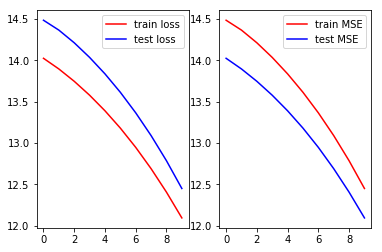

In [56]:
# 
import matplotlib.pylab as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.plot(list(range(10)), hist['val_loss'], color='r', label='train loss')
plt.plot(list(range(10)), hist['loss'], color='b', label='test loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(list(range(10)), hist['mean_squared_error'], color='r', label='train MSE')
plt.plot(list(range(10)), hist['val_mean_squared_error'], color='b', label='test MSE')
plt.legend()
# plt.show()

In [57]:
# Predict
test_pred = model.predict(test_model_input, batch_size=256)
test_pred[:5]

array([[0.29604125],
       [0.29555818],
       [0.29606527],
       [0.29544395],
       [0.29584858]], dtype=float32)

In [60]:
# MSE or RMSE
mse = round(mean_squared_error(test[target].values, test_pred), 4)
rmse = mse ** 0.5
print("test RMSE", rmse)

test RMSE 3.3295194848506293
